# Bank Campaign Clustering and Regression
ARMA, ARIMA, SARIMA reference: https://builtin.com/data-science/time-series-forecasting-python

#### Data Dictionary
- age
- job: type of job (e.g. 'admin', 'technician', 'unemployed', etc)
- marital: marital status ('married', 'single', 'divorced', 'unknown')
- education: level of education ('basic.4y', 'high.school', 'basic.6y', 'basic.9y','professional.course', 'unknown','university.degree','illiterate')
- default: if the client has credit in default ('no', 'unknown', 'yes')
- housing: if the client has housing a loan ('no', 'unknown', 'yes')
- loan: if the client has a personal loan ? ('no', 'unknown', 'yes')
- contact: type of communication ('telephone', 'cellular')
- month: month of last contact
- day_of_week: day of last contact
- duration: call duration (in seconds)
- duration = call duration (in seconds)
- campaign = number of contacts performed during this campaign and for this client
- pdays = number of days passed by after the client was last contacted from a previous campaign
- previous = number of contacts performed before this campaign and for this client
- poutcome: outcome of previous marketing campaign ('nonexistent', 'failure', 'success')

#### Numeric mappings
Job
- 0: admin
- 1: blue-collar
- 2: entrepreneur
- 3: housemaid
- 4: management
- 5: retired
- 6: self-employed
- 7: services
- 8: student
- 9: technician
- 10: unemployed
- 11: unknown

Marital
- divorced: 0
- married: 1
- single: 2
- unknown: 3

Education
- basic.4y: 0
- basic.6y: 1
- basic.9y: 2
- high.school: 3
- illiterate: 4
- professional.course: 5
- university.degree: 6
- unknown: 7

Default
- no: 0
- unknown: 1
- yes: 2

Housing
- no: 0
- unknown: 1
- yes: 2

Loan
- no: 0
- unknown: 1
- yes: 2

Contact
- cellular: 0
- telephone: 1

Outcome
- failure: 0
- nonexistent: 1
- success: 2

Subscribed
- no: 0
- yes: 1

Age
- 11-20: 0
- 21-30: 1
- 31-40: 2
- 41-50: 3
- 51-60: 4
- 61-70: 5
- 71-80: 6
- 81-90: 7
- 91-100: 8

Duration
- 0-1000: 0
- 1001-2000: 1
- 2001-3000: 2
- 3001-4000: 3
- 4001-5000: 4

Campaign
- 0-10: 0
- 11-20: 1
- 21-30: 2
- 31-40: 3
- 41-50: 4
- 51-60: 5

Pdays
- 0-10: 0
- 11-20: 1
- 21-30: 2
- 30+: 3

Previous
- 0: 0
- 1-5: 1
- 5-10: 2

Subscribed
- no: 0
- yes: 1

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# STEP 1: Data Cleanup and Preperation

In [2]:
# load data
df_original = pd.read_csv("/Users/nuremek/Documents/MADS/SIADS696/Bank_Campaign.csv")
df = df_original.copy()

# remove unnecessary columns
del df['emp.var.rate']
del df['cons.price.idx']
del df['cons.conf.idx']
del df['euribor3m']
del df['nr.employed']

# transform and concatenate month and day of week
month = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

df['month'] = df['month'].map(month)
df['day_of_week'] = df['day_of_week'].map(day)
df['date'] = df['month'].map(month)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,1,261,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,5,1,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,5,1,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,5,1,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,5,1,307,1,999,0,nonexistent,no


In [56]:
df_loans = df[['housing','loan']]
df_loans.rename(columns={"housing": "Housing Loan", "loan": "Personal Loan"}, inplace=True)
df_loans_pivot = df_loans.melt(var_name='columns', value_name='index')
df_loans_count = pd.crosstab(index=df_loans_pivot['index'], columns=df_loans_pivot['columns'])
df_loans_count.rename_axis(None)

/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



columns,Housing Loan,Personal Loan
no,18622,33950
unknown,990,990
yes,21576,6248


/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



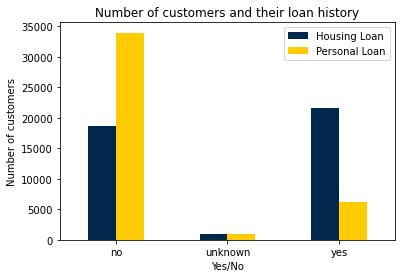

In [54]:
df_loans = df[['housing','loan']]
df_loans.rename(columns={"housing": "Housing Loan", "loan": "Personal Loan"}, inplace=True)
df1 = df_loans.melt(var_name='columns', value_name='index')
df_loans_count = pd.crosstab(index=df1['index'], columns=df1['columns'])
df_loans_count.rename_axis(None, inplace=True)

ax = df_loans_count.plot.bar(figsize=(6,4), color={"Housing Loan": "#00274C", "Personal Loan": "#FFCB05"})
# for container in ax.containers:
#     ax.bar_label(container, size=8)

plt.ylabel("Number of customers")
plt.xlabel("Yes/No")
plt.xticks(rotation=0)
plt.title("Number of customers and their loan history")
plt.legend()
plt.show()

In [55]:
df['contact_growth'] = (df['campaign'] - df['previous']) / df['previous'] # calculate growth in number of times contacted from previous campaign vs current campaign

fig = px.scatter_matrix(
    df,
    dimensions=["duration","campaign","previous","contact_growth"],
    labels={'duration':'Call Duration (sec)','campaign':'Current <br> Campaign Calls','previous':'Previous <br> Campaign Calls','contact_growth':'Growth from Previous <br> to Current Campaign (%)'},
    color="subscribed",
    color_discrete_sequence=['#00274C','#FFCB05']
)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title_x=0.5,
    title_text="Splom scatter plot showing correlations between campaign <br> performance metrics by subscription"
)

fig.show()

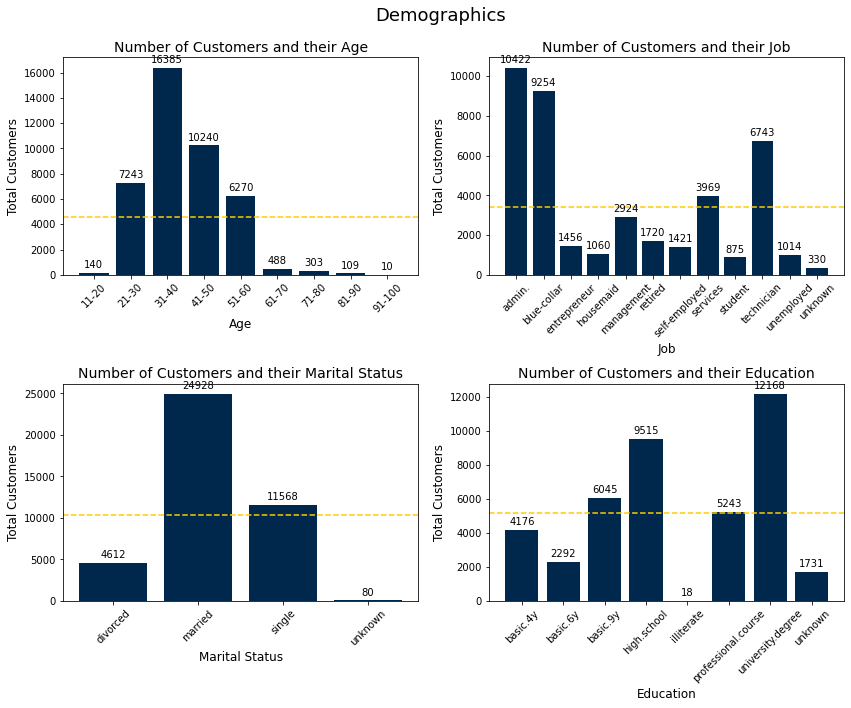

In [138]:
df_demo = df.copy()

# bin age
age_bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100']
df_demo['age_binned'] = pd.cut(df_demo['age'], bins=age_bins, labels=age_labels)
del df_demo['age']

df_demo.rename(columns={'age_binned':'Age','job':'Job','marital':'Marital Status','education':'Education'}, inplace=True)

def demographics(columns):

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    fig.suptitle("Demographics", fontsize=18, y=0.95)
    plt.subplots_adjust(hspace=0.5)
    
    for n, column in enumerate(columns):
        # prep data
        df = df_demo[[column]]
        df_pivot = df.melt(var_name='columns', value_name='index')
        df_count = pd.crosstab(index=df_pivot['index'], columns=df_pivot['columns'])
        df_count.rename_axis(None, inplace=True)
            
        # plot each attribute into its own bar chart
        plt.subplot(2, 2, n+1)
        bars = plt.bar(df_count.index, df_count[column], color='#00274C') # '#00274C','#FFCB05'
        for bar in bars:
            yval = bar.get_height()
            plt.annotate(f'{yval}', 
                         xy=(bar.get_x() + bar.get_width() / 2, yval), 
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords='offset points',
                         ha='center', va='bottom')

        # plot average
        plt.axhline(y=df_count[column].mean(), color='#FFCB05', ls='--') # '#00274C','#FFCB05'
        
        plt.ylabel('Total Customers',fontsize=12)
        plt.xlabel(column, fontsize=12)
        plt.xticks(rotation=45)
        plt.title(f'Number of Customers and their ' + column, fontsize=14)

columns = ['Age','Job','Marital Status','Education']
demographics(columns)

In [3]:
# bin age, duration, campaign, pdays, previous

# bin age
# age_bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# age_labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100']
# df['age_binned'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# # bin duration
# duration_bins = [-1, 1000, 2000, 3000, 4000, 5000]
# duration_labels = ['0-1000','1001-2000','2001-3000','3001-4000','4001-5000']
# df['duration_binned'] = pd.cut(df['duration'], bins=duration_bins, labels=duration_labels)

# # bin campaign
# campaign_bins = [-1, 10, 20, 30, 40, 50, 60]
# campaign_labels = ['0-10','11-20','21-30','31-40','41-50','51-60']
# df['campaign_binned'] = pd.cut(df['campaign'], bins=campaign_bins, labels=campaign_labels)

# # bin pdays
# pdays_bins = [-1, 10, 20, 30, 1000]
# pdays_labels = ['0-10','11-20','21-30','30+']
# df['pdays_binned'] = pd.cut(df['pdays'], bins=pdays_bins, labels=pdays_labels)

# # bin previous
# previous_bins = [-1, 0, 5, 10]
# previous_labels = ['0','1-5','5-10']
# df['previous_binned'] = pd.cut(df['previous'], bins=previous_bins, labels=previous_labels)

# del df['age']
# del df['duration']
# del df['campaign']
# del df['pdays']
# del df['previous']

# df.head(5)

In [4]:
# encode categorical columns to numeric
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

columns = ['job','marital','education','default','housing','loan','contact','poutcome'] #'age_binned','duration_binned','campaign_binned','pdays_binned','previous_binned']
for column in columns:
    df[column] = le.fit_transform(df[column])

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,subscribed
0,56,3,1,0,0,0,0,1,5,1,261,1,999,0,1,no
1,57,7,1,3,1,0,0,1,5,1,149,1,999,0,1,no
2,37,7,1,3,0,2,0,1,5,1,226,1,999,0,1,no
3,40,0,1,1,0,0,0,1,5,1,151,1,999,0,1,no
4,56,7,1,3,0,0,2,1,5,1,307,1,999,0,1,no


In [5]:
# prepare data using one hot encoder to encode categories to numeric values
df_clean = df.drop(columns = ['subscribed']) # remove subscribed from model since we're trying to predict this variable

encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(df_clean).toarray()

# Convert the encoded data to a DataFrame
encoded_feature_names = encoder.get_feature_names_out(df_clean.columns)
df_encoded = pd.DataFrame(data_encoded, columns=encoded_feature_names)

df_encoded.head()

,age_17,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,...,previous_1,previous_2,previous_3,previous_4,previous_5,previous_6,previous_7,poutcome_0,poutcome_1,poutcome_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# STEP 2: Find optimal clusters
Elbow Method vs Davies-Bouldin Index

### Elbow Method

/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

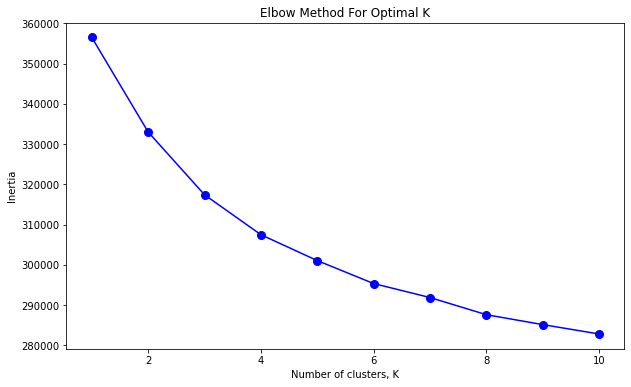

In [6]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_encoded)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

### Davies-Bouldin Index

/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

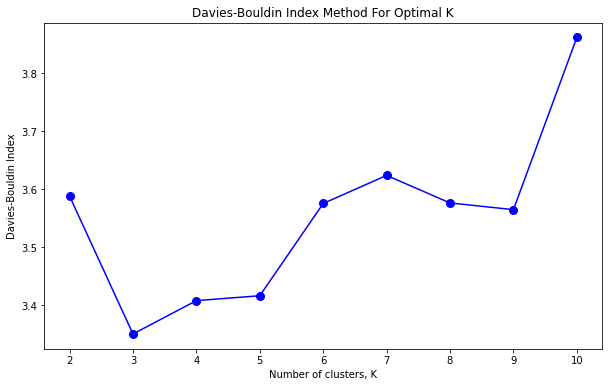

In [7]:
davies_bouldin_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_encoded)
    score = davies_bouldin_score(data_encoded, kmeans.labels_)
    davies_bouldin_scores.append(score)

# Plot the Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(K, davies_bouldin_scores, 'bo-', markersize=8)
plt.xlabel('Number of clusters, K')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method For Optimal K')
plt.show()

# STEP 3: K-Means Clustering (Unsupervised)

In [8]:
# k means resource: https://www.askpython.com/python/examples/plot-k-means-clusters-python

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_encoded)
clusters = kmeans.labels_
df_encoded['cluster'] = clusters
df_original['cluster'] = clusters # add to original dataframe to later be used for Logistic Regression

/Users/nuremek/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# STEP 4: Dimensionality Reduction (Unsupervised)

### K-means using PCA to reduce data to 2 dimensions

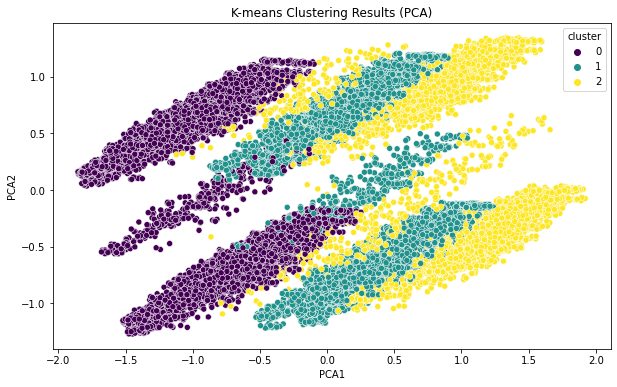

In [9]:
# Use PCA with 14 dimensions
pca = PCA(n_components=14)
data_pca = pca.fit_transform(df_encoded.drop('cluster', axis=1))

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = df_encoded['cluster']

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='viridis', data=df_pca)
plt.title('K-means Clustering Results (PCA)')
plt.show()

### K-means using t-SNE to reduce dimensionality to 2 components

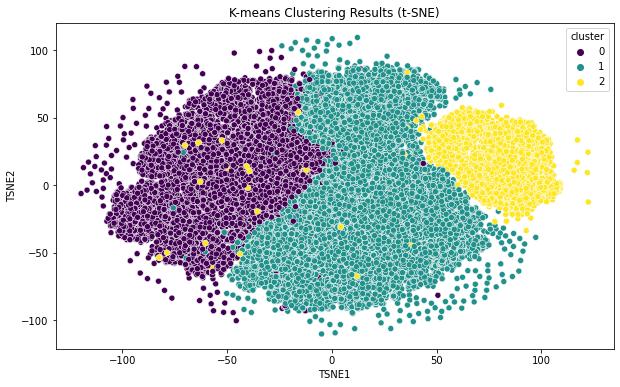

In [10]:
# Perform t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne = tsne.fit_transform(df_encoded.drop('cluster', axis=1))

# Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = df_encoded['cluster']

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', palette='viridis', data=df_tsne)
plt.title('K-means Clustering Results (t-SNE)')
plt.show()

# STEP 5: Logistic Regression (Supervised)

0.8876750020231448


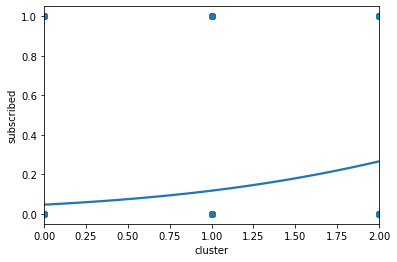

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df_original['subscribed'] = le.fit_transform(df_original['subscribed']) # encode yes/no to numeric

X = df_original['cluster']
y = df_original['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression().fit(np.array(X_train).reshape(-1, 1), y_train)
# cross_val_score(logreg, np.array(X_train).reshape(-1,1), km.labels_, cv = 5)

y_pred = logreg.predict(np.array(X_test).reshape(-1, 1))
score = accuracy_score(y_test,y_pred)

sns.regplot(x=X, y=y, data=df_original, logistic=True, ci=None)
print(score)

# use f2

In [12]:
accuracy = len(df_original[df_original['subscribed']==1]) / len(df_original[df_original['cluster']==2])
print(accuracy)

0.8254758939690446


In [13]:
print(len(df_original[df_original['subscribed']==1]))
print(len(df_original[df_original['cluster']==2]))

4640
5621


In [14]:
len(df_original)

41188

In [ ]:
# confusion matrix, heatmap PCA components for more important features